In [1]:
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data/ashok_mar19_mar20.csv',index_col=0)
# dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['PM2.5','AT','BP','PM10','Benzene','Toluene','NH3','NO','NO2','NOx','RH','SR','WS','WD','Ozone','SO2','CO']
dataset.index.name = 'Date'
# mark all NA values with 0
dataset['PM2.5'].fillna(0, inplace=True)
# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')


/home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


                   PM2.5     AT      BP    PM10  Benzene  Toluene     NH3  \
Date                                                                        
19-03-2019 00:00  113.77  23.11  986.47  222.69    53.77   176.33  149.05   
20-03-2019 00:00   91.92  25.82  984.78  223.62    47.16   149.60  130.92   
21-03-2019 00:00  111.44  24.86  988.30  178.79    50.40   164.93  116.82   
22-03-2019 00:00   38.00  23.95  990.27  126.25    40.88   188.77  208.38   
23-03-2019 00:00   57.73  24.03  989.49  148.54    44.30   181.58  197.88   

                    NO   NO2    NOx     RH     SR     WS     WD  Ozone    SO2  \
Date                                                                            
19-03-2019 00:00  0.63  7.77  33.77  27.21  48.00  77.84  80.51  42.99  31.07   
20-03-2019 00:00  0.67  7.92  24.46  30.84  23.99  59.80  51.34  49.98  23.85   
21-03-2019 00:00  0.84  6.56   9.08  36.49   3.68  32.57  19.23  55.16  25.41   
22-03-2019 00:00  0.43  2.36   6.75  27.38   2.53  40.0

(367, 17)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


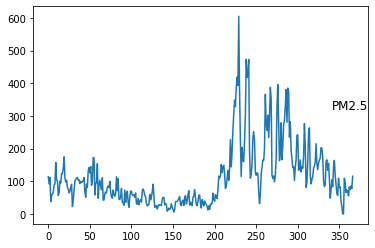

array([113.77,  91.92, 111.44,  38.  ,  57.73,  60.06,  67.29,  88.12,
        91.77, 157.31, 105.08, 100.15,  56.69,  65.1 , 100.29,  95.12,
       123.06, 123.73, 139.91, 174.84, 110.79,  97.53, 102.84,  81.23,
        76.31,  64.34,  69.62,  81.96,  90.71,  22.73,  41.08,  73.48,
       100.27, 106.03, 108.83, 111.8 , 103.97, 104.17,  93.28,  99.89,
        96.22,  98.69, 101.96, 111.21,  66.72,  51.06,  91.48,  81.07,
       131.89, 141.84, 125.24, 145.32,  87.48, 102.03, 172.4 , 171.62,
        58.25,  93.83,  94.94, 153.67,  48.06,  86.77, 103.08,  86.68,
        73.81, 110.52,  42.08,  42.75,  61.72,  67.23,  64.38,  81.93,
        85.09,  80.79,  99.54,  67.54,  52.81,  48.08,  73.06,  61.52,
        53.9 ,  61.72, 113.77,  71.09, 107.66,  44.78,  43.96,  52.42,
        78.  ,  35.46,  33.82,  26.66,  73.15,  35.49,  61.31,  69.42,
        36.1 ,  20.46,  50.94,  69.85,  69.35,  57.62,  56.04,  58.54,
        51.02,  64.15,  31.67,  29.65,  47.54,  28.15,  38.53,  43.78,
      

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print(values.shape)
# specify columns to plot
groups=[]
for i in range(values.shape[1]):
    groups.append(i)
# groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,14,]
print(groups)
i = 1
# plot each column
pyplot.figure()
# for group in groups:
#     pyplot.subplot(len(groups), 1, i)
#     pyplot.plot(values[:, group])
#     print(group)
#     pyplot.title(dataset.columns[group], y=0.5, loc='right')
#     i += 1
pyplot.plot(values[:,0])
#     print(group)
pyplot.title(dataset.columns[0], y=0.5, loc='right')
pyplot.show()
values[:,0]

(367, 17)


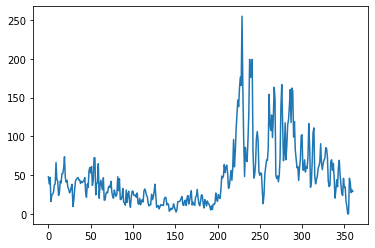

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 255))
print(values.shape)
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_hours= 6
# n_hours = 3
n_features = values.shape[1]
reframed = series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
d=[]
for j in range(values.shape[1],values.shape[1]*2):
    d.append(j)
# reframed.drop(reframed.columns[[13,14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
reframed.drop(reframed.columns[d], axis=1, inplace=True)
# print(reframed.head())
# print(reframed)
pyplot.figure()

pyplot.plot(reframed.values[:,0])
pyplot.show()

(300, 102) 300 (300,) (61, 102)
(300, 6, 17) (300,) (61, 6, 17) (61,)


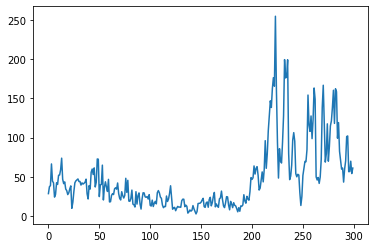

In [4]:
# split into train and test sets
values = reframed.values
n_train_hours = 300 * 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape,test_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# train_y
pyplot.figure()

pyplot.plot(train_y)
pyplot.show()


Train on 300 samples, validate on 61 samples
Epoch 1/100
 - 4s - loss: 0.1298 - val_loss: 0.0992
Epoch 2/100
 - 0s - loss: 0.0741 - val_loss: 0.0656
Epoch 3/100
 - 0s - loss: 0.0697 - val_loss: 0.0675
Epoch 4/100
 - 0s - loss: 0.0626 - val_loss: 0.0633
Epoch 5/100
 - 0s - loss: 0.0591 - val_loss: 0.0591
Epoch 6/100
 - 0s - loss: 0.0620 - val_loss: 0.0567
Epoch 7/100
 - 0s - loss: 0.0661 - val_loss: 0.0663
Epoch 8/100
 - 0s - loss: 0.0838 - val_loss: 0.0575
Epoch 9/100
 - 0s - loss: 0.0614 - val_loss: 0.0597
Epoch 10/100
 - 0s - loss: 0.0659 - val_loss: 0.0549
Epoch 11/100
 - 0s - loss: 0.0562 - val_loss: 0.0533
Epoch 12/100
 - 0s - loss: 0.0509 - val_loss: 0.0540
Epoch 13/100
 - 0s - loss: 0.0486 - val_loss: 0.0513
Epoch 14/100
 - 0s - loss: 0.0462 - val_loss: 0.0571
Epoch 15/100
 - 0s - loss: 0.0436 - val_loss: 0.0531
Epoch 16/100
 - 0s - loss: 0.0396 - val_loss: 0.0450
Epoch 17/100
 - 0s - loss: 0.0490 - val_loss: 0.0446
Epoch 18/100
 - 0s - loss: 0.0448 - val_loss: 0.0748
Epoch 19/1

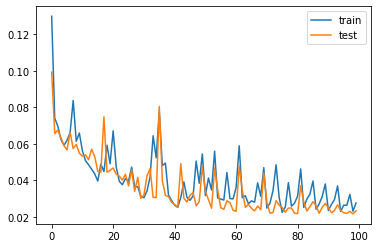

ValueError: operands could not be broadcast together with shapes (61,102) (17,) (61,102) 

In [91]:
# design network LSTM
model = Sequential()
model.add(LSTM(128,activation='relu' ,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(256,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=25, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# make a prediction
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]*test_X.shape[1]))
# print(test_X.shape)
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(values.shape[1]-1):]), axis=1)
# print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(values.shape[1]-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 20.030


(300, 102) 300 (300,) (61, 102)
Train on 300 samples, validate on 61 samples
Epoch 1/500
 - 6s - loss: 0.0324 - val_loss: 0.0086
Epoch 2/500
 - 0s - loss: 0.0175 - val_loss: 0.0074
Epoch 3/500
 - 0s - loss: 0.0138 - val_loss: 0.0058
Epoch 4/500
 - 0s - loss: 0.0088 - val_loss: 0.0046
Epoch 5/500
 - 0s - loss: 0.0093 - val_loss: 0.0052
Epoch 6/500
 - 0s - loss: 0.0098 - val_loss: 0.0041
Epoch 7/500
 - 0s - loss: 0.0185 - val_loss: 0.0070
Epoch 8/500
 - 0s - loss: 0.0075 - val_loss: 0.0089
Epoch 9/500
 - 0s - loss: 0.0078 - val_loss: 0.0054
Epoch 10/500
 - 0s - loss: 0.0065 - val_loss: 0.0046
Epoch 11/500
 - 0s - loss: 0.0059 - val_loss: 0.0044
Epoch 12/500
 - 0s - loss: 0.0063 - val_loss: 0.0042
Epoch 13/500
 - 0s - loss: 0.0063 - val_loss: 0.0038
Epoch 14/500
 - 0s - loss: 0.0100 - val_loss: 0.0032
Epoch 15/500
 - 0s - loss: 0.0072 - val_loss: 0.0058
Epoch 16/500
 - 0s - loss: 0.0097 - val_loss: 0.0035
Epoch 17/500
 - 0s - loss: 0.0050 - val_loss: 0.0063
Epoch 18/500
 - 0s - loss: 0.00

Epoch 146/500
 - 0s - loss: 6.4536e-04 - val_loss: 6.5135e-04
Epoch 147/500
 - 0s - loss: 7.4407e-04 - val_loss: 5.9517e-04
Epoch 148/500
 - 0s - loss: 6.1525e-04 - val_loss: 6.3633e-04
Epoch 149/500
 - 0s - loss: 6.9758e-04 - val_loss: 5.8659e-04
Epoch 150/500
 - 0s - loss: 5.7994e-04 - val_loss: 6.2297e-04
Epoch 151/500
 - 0s - loss: 6.6069e-04 - val_loss: 5.7575e-04
Epoch 152/500
 - 0s - loss: 5.5908e-04 - val_loss: 6.0477e-04
Epoch 153/500
 - 0s - loss: 6.3395e-04 - val_loss: 5.6667e-04
Epoch 154/500
 - 0s - loss: 5.3102e-04 - val_loss: 5.9068e-04
Epoch 155/500
 - 0s - loss: 6.0194e-04 - val_loss: 5.4776e-04
Epoch 156/500
 - 0s - loss: 5.2373e-04 - val_loss: 5.8665e-04
Epoch 157/500
 - 0s - loss: 5.7637e-04 - val_loss: 5.4850e-04
Epoch 158/500
 - 0s - loss: 4.9550e-04 - val_loss: 5.7989e-04
Epoch 159/500
 - 0s - loss: 5.4776e-04 - val_loss: 5.4856e-04
Epoch 160/500
 - 0s - loss: 4.8513e-04 - val_loss: 5.7453e-04
Epoch 161/500
 - 0s - loss: 5.5202e-04 - val_loss: 5.4494e-04
Epoch 16

Epoch 279/500
 - 0s - loss: 9.5106e-05 - val_loss: 3.8470e-04
Epoch 280/500
 - 0s - loss: 1.3298e-04 - val_loss: 3.7858e-04
Epoch 281/500
 - 0s - loss: 1.3038e-04 - val_loss: 4.6108e-04
Epoch 282/500
 - 0s - loss: 1.4071e-04 - val_loss: 3.6998e-04
Epoch 283/500
 - 0s - loss: 1.3594e-04 - val_loss: 3.5992e-04
Epoch 284/500
 - 0s - loss: 1.8577e-04 - val_loss: 4.7465e-04
Epoch 285/500
 - 0s - loss: 2.7942e-04 - val_loss: 4.2736e-04
Epoch 286/500
 - 0s - loss: 2.2361e-04 - val_loss: 4.7079e-04
Epoch 287/500
 - 0s - loss: 1.9857e-04 - val_loss: 3.7556e-04
Epoch 288/500
 - 0s - loss: 1.8584e-04 - val_loss: 3.7716e-04
Epoch 289/500
 - 0s - loss: 2.4297e-04 - val_loss: 5.2666e-04
Epoch 290/500
 - 0s - loss: 3.2509e-04 - val_loss: 4.4887e-04
Epoch 291/500
 - 0s - loss: 2.4506e-04 - val_loss: 4.7609e-04
Epoch 292/500
 - 0s - loss: 1.7739e-04 - val_loss: 3.8438e-04
Epoch 293/500
 - 0s - loss: 8.3027e-05 - val_loss: 3.5844e-04
Epoch 294/500
 - 0s - loss: 7.3600e-05 - val_loss: 3.6298e-04
Epoch 29

 - 0s - loss: 1.2410e-04 - val_loss: 4.4230e-04
Epoch 412/500
 - 0s - loss: 1.0499e-04 - val_loss: 3.9703e-04
Epoch 413/500
 - 0s - loss: 8.1547e-05 - val_loss: 3.1666e-04
Epoch 414/500
 - 0s - loss: 5.3583e-05 - val_loss: 3.0641e-04
Epoch 415/500
 - 0s - loss: 8.0834e-05 - val_loss: 4.1536e-04
Epoch 416/500
 - 0s - loss: 1.4100e-04 - val_loss: 4.6590e-04
Epoch 417/500
 - 0s - loss: 1.2153e-04 - val_loss: 4.0273e-04
Epoch 418/500
 - 0s - loss: 9.3474e-05 - val_loss: 2.8844e-04
Epoch 419/500
 - 0s - loss: 1.2133e-04 - val_loss: 4.0546e-04
Epoch 420/500
 - 0s - loss: 2.0221e-04 - val_loss: 6.4080e-04
Epoch 421/500
 - 0s - loss: 2.4990e-04 - val_loss: 5.3671e-04
Epoch 422/500
 - 0s - loss: 1.4425e-04 - val_loss: 3.1481e-04
Epoch 423/500
 - 0s - loss: 1.1061e-04 - val_loss: 3.7938e-04
Epoch 424/500
 - 0s - loss: 2.5687e-04 - val_loss: 6.2926e-04
Epoch 425/500
 - 0s - loss: 3.1454e-04 - val_loss: 6.4476e-04
Epoch 426/500
 - 0s - loss: 2.6808e-04 - val_loss: 4.1538e-04
Epoch 427/500
 - 0s - 

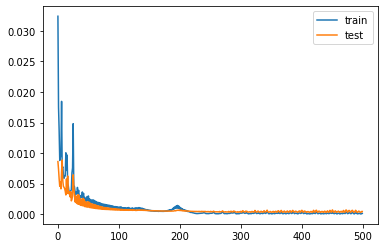

In [93]:
values = reframed.values
n_train_hours = 300 * 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape,test_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
#Endcode Decoder model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
n_steps_out=1
train_y=train_y.reshape(train_y.shape[0],1,1)
test_y=test_y.reshape(test_y.shape[0],1,1)
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(RepeatVector(n_steps_out))
model1.add(LSTM(100, activation='relu', return_sequences=True))
model1.add(TimeDistributed(Dense(1)))
model1.compile(optimizer='adam', loss='mse')
# fit model
history1=model1.fit(train_X, train_y, epochs=500, batch_size=25, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

(300, 100) (61, 100)
300
61
(300, 10, 10, 3) (61, 10, 10, 3)


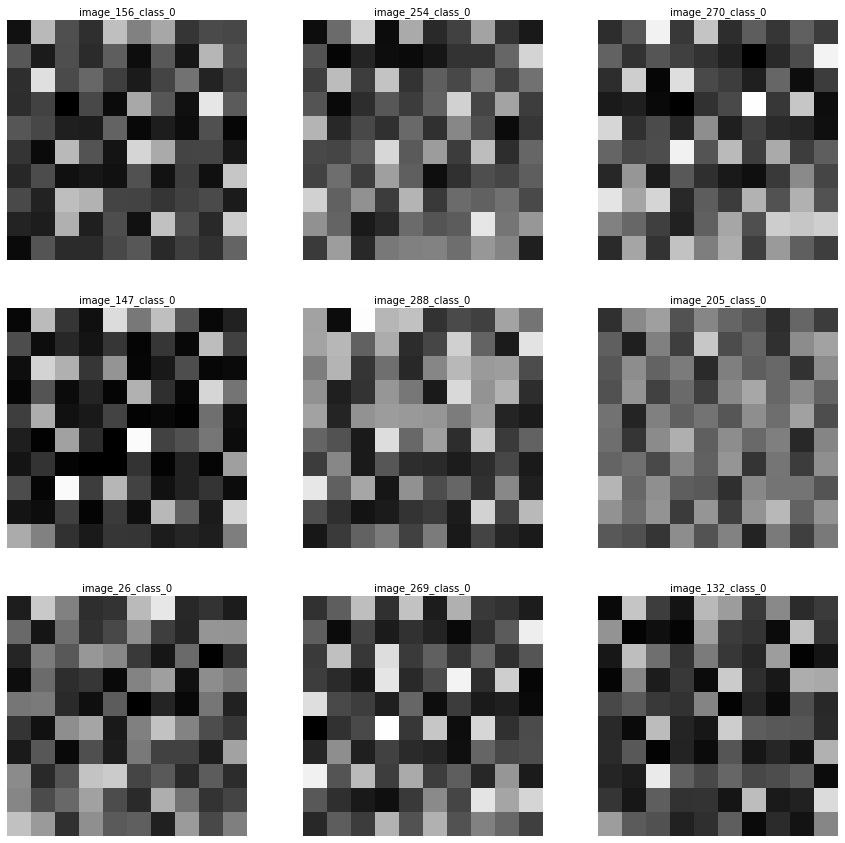

In [5]:
def reshape_as_image(x, img_width, img_height):
    print(x.shape[0])
    x_temp = np.zeros((x.shape[0], int(img_height), int(img_width)),dtype=int)
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (int(img_height), int(img_width)))

    return x_temp
train_X1=train_X.reshape(train_X.shape[0],train_X.shape[1]*train_X.shape[2])
test_X1=test_X.reshape(test_X.shape[0],test_X.shape[1]*test_X.shape[2])
train_X1=train_X1[:,0:100]
test_X1=test_X1[:,0:100]
print(train_X1.shape,test_X1.shape)
dim=np.sqrt(train_X1.shape[1])
x_train=reshape_as_image(train_X1,dim,dim)
x_test=reshape_as_image(test_X1,dim,dim)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
print(x_train.shape,x_test.shape)
from matplotlib import pyplot as plt
%matplotlib inline
x_train=x_train/255.0
x_test=x_test/255.0
fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(train_y[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()


In [6]:
from util import models
from keras.optimizers import Adam

model = models.create_cnn(10, 10, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

W0324 03:49:49.653976 140611845691136 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0324 03:49:49.886596 140611845691136 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0324 03:49:49.914498 140611845691136 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0324 03:49:50.011047 140611845691136 deprecation_wrapper.py:119] From /home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_sessi

In [9]:
print("[INFO] training model...")
H=model.fit(x_train, train_y, epochs=1000, batch_size=25, validation_data=(x_test, test_y), verbose=2, shuffle=False)

[INFO] training model...
Train on 300 samples, validate on 61 samples
Epoch 1/1000
 - 2s - loss: 46.2073 - val_loss: 770109246.5218
Epoch 2/1000
 - 0s - loss: 44.6254 - val_loss: 780543609.3036
Epoch 3/1000
 - 0s - loss: 45.5390 - val_loss: 698111134.7099
Epoch 4/1000
 - 0s - loss: 44.2846 - val_loss: 640734240.4942
Epoch 5/1000
 - 0s - loss: 45.4031 - val_loss: 605909484.1558
Epoch 6/1000
 - 0s - loss: 40.9181 - val_loss: 659577209.3506
Epoch 7/1000
 - 0s - loss: 41.5052 - val_loss: 658817495.6923
Epoch 8/1000
 - 0s - loss: 45.2775 - val_loss: 713679874.2734
Epoch 9/1000
 - 0s - loss: 43.5762 - val_loss: 740108778.3669
Epoch 10/1000
 - 0s - loss: 40.6211 - val_loss: 724887898.7493
Epoch 11/1000
 - 0s - loss: 41.7864 - val_loss: 706737287.4777
Epoch 12/1000
 - 0s - loss: 43.8994 - val_loss: 675625311.0133
Epoch 13/1000
 - 0s - loss: 43.9733 - val_loss: 674244329.3079
Epoch 14/1000
 - 0s - loss: 42.5415 - val_loss: 717459119.6856
Epoch 15/1000
 - 0s - loss: 42.5575 - val_loss: 691352836

Epoch 129/1000
 - 0s - loss: 35.8926 - val_loss: 951673308.4150
Epoch 130/1000
 - 0s - loss: 34.5196 - val_loss: 793025128.1871
Epoch 131/1000
 - 0s - loss: 33.9028 - val_loss: 865640317.0507
Epoch 132/1000
 - 0s - loss: 35.8799 - val_loss: 1442851070.8473
Epoch 133/1000
 - 0s - loss: 35.1903 - val_loss: 1978290171.5617
Epoch 134/1000
 - 0s - loss: 36.7388 - val_loss: 952480866.2037
Epoch 135/1000
 - 0s - loss: 35.7544 - val_loss: 790184893.9972
Epoch 136/1000
 - 0s - loss: 34.8746 - val_loss: 829423443.7181
Epoch 137/1000
 - 0s - loss: 37.1905 - val_loss: 1143081465.8725
Epoch 138/1000
 - 0s - loss: 33.7178 - val_loss: 976748506.5684
Epoch 139/1000
 - 0s - loss: 33.9001 - val_loss: 882812977.0890
Epoch 140/1000
 - 0s - loss: 33.0778 - val_loss: 869095993.6057
Epoch 141/1000
 - 0s - loss: 36.8407 - val_loss: 897587744.9288
Epoch 142/1000
 - 0s - loss: 36.9074 - val_loss: 761371517.0297
Epoch 143/1000
 - 0s - loss: 35.7125 - val_loss: 813928425.5630
Epoch 144/1000
 - 0s - loss: 35.2463 

Epoch 257/1000
 - 0s - loss: 28.1703 - val_loss: 757843955.8565
Epoch 258/1000
 - 0s - loss: 30.9542 - val_loss: 779666646.3462
Epoch 259/1000
 - 0s - loss: 30.8328 - val_loss: 789205268.1395
Epoch 260/1000
 - 0s - loss: 30.8287 - val_loss: 745489336.3855
Epoch 261/1000
 - 0s - loss: 32.2566 - val_loss: 750582214.8549
Epoch 262/1000
 - 0s - loss: 33.6496 - val_loss: 742029924.9126
Epoch 263/1000
 - 0s - loss: 31.0062 - val_loss: 754108876.6466
Epoch 264/1000
 - 0s - loss: 29.8217 - val_loss: 730152471.3781
Epoch 265/1000
 - 0s - loss: 33.0403 - val_loss: 756979276.1020
Epoch 266/1000
 - 0s - loss: 30.5356 - val_loss: 755981975.5264
Epoch 267/1000
 - 0s - loss: 31.2570 - val_loss: 739358026.5143
Epoch 268/1000
 - 0s - loss: 30.3032 - val_loss: 716776360.2715
Epoch 269/1000
 - 0s - loss: 33.2221 - val_loss: 727837344.2301
Epoch 270/1000
 - 0s - loss: 29.6592 - val_loss: 718506510.6145
Epoch 271/1000
 - 0s - loss: 31.7927 - val_loss: 712569565.9948
Epoch 272/1000
 - 0s - loss: 30.1527 - v

Epoch 385/1000
 - 0s - loss: 27.8249 - val_loss: 822820951.2555
Epoch 386/1000
 - 0s - loss: 25.8693 - val_loss: 824332402.8135
Epoch 387/1000
 - 0s - loss: 27.1190 - val_loss: 870281150.0232
Epoch 388/1000
 - 0s - loss: 26.5520 - val_loss: 802707118.6084
Epoch 389/1000
 - 0s - loss: 25.1004 - val_loss: 796627170.2753
Epoch 390/1000
 - 0s - loss: 27.9942 - val_loss: 817517819.3933
Epoch 391/1000
 - 0s - loss: 25.6741 - val_loss: 823605427.0698
Epoch 392/1000
 - 0s - loss: 26.7179 - val_loss: 851495682.7391
Epoch 393/1000
 - 0s - loss: 26.9133 - val_loss: 849872862.8550
Epoch 394/1000
 - 0s - loss: 25.3416 - val_loss: 857543001.4385
Epoch 395/1000
 - 0s - loss: 25.4544 - val_loss: 866932377.5229
Epoch 396/1000
 - 0s - loss: 26.2254 - val_loss: 839951185.5910
Epoch 397/1000
 - 0s - loss: 25.8621 - val_loss: 804701400.2368
Epoch 398/1000
 - 0s - loss: 27.8877 - val_loss: 779611301.4650
Epoch 399/1000
 - 0s - loss: 25.4229 - val_loss: 779504547.6678
Epoch 400/1000
 - 0s - loss: 25.8192 - v

Epoch 513/1000
 - 0s - loss: 23.8983 - val_loss: 2342034479.0175
Epoch 514/1000
 - 0s - loss: 24.8240 - val_loss: 1840441091.5426
Epoch 515/1000
 - 0s - loss: 25.1694 - val_loss: 1453373917.9758
Epoch 516/1000
 - 0s - loss: 24.8284 - val_loss: 1252360306.4353
Epoch 517/1000
 - 0s - loss: 24.4374 - val_loss: 1168109973.7014
Epoch 518/1000
 - 0s - loss: 23.2300 - val_loss: 870827613.6381
Epoch 519/1000
 - 0s - loss: 24.8434 - val_loss: 876131215.4206
Epoch 520/1000
 - 0s - loss: 23.8552 - val_loss: 890834793.7737
Epoch 521/1000
 - 0s - loss: 24.5264 - val_loss: 877745166.6639
Epoch 522/1000
 - 0s - loss: 27.1035 - val_loss: 880249193.7950
Epoch 523/1000
 - 0s - loss: 25.0025 - val_loss: 885970268.8203
Epoch 524/1000
 - 0s - loss: 23.9226 - val_loss: 952143330.2923
Epoch 525/1000
 - 0s - loss: 24.2405 - val_loss: 1240099369.9005
Epoch 526/1000
 - 0s - loss: 23.6910 - val_loss: 1069827579.7953
Epoch 527/1000
 - 0s - loss: 25.5935 - val_loss: 925577665.7549
Epoch 528/1000
 - 0s - loss: 24.3

 - 0s - loss: 23.3496 - val_loss: 920939243.8213
Epoch 641/1000
 - 0s - loss: 23.2413 - val_loss: 893813524.9970
Epoch 642/1000
 - 0s - loss: 24.2102 - val_loss: 878613993.9735
Epoch 643/1000
 - 0s - loss: 23.1291 - val_loss: 888770742.7217
Epoch 644/1000
 - 0s - loss: 23.5732 - val_loss: 905468553.6551
Epoch 645/1000
 - 0s - loss: 22.1358 - val_loss: 1199952593.9647
Epoch 646/1000
 - 0s - loss: 21.4676 - val_loss: 1243692499.7866
Epoch 647/1000
 - 0s - loss: 22.2285 - val_loss: 1364080381.2627
Epoch 648/1000
 - 0s - loss: 22.2310 - val_loss: 1231301680.6104
Epoch 649/1000
 - 0s - loss: 23.2372 - val_loss: 1121756133.2486
Epoch 650/1000
 - 0s - loss: 23.5806 - val_loss: 1117987477.6428
Epoch 651/1000
 - 0s - loss: 24.2499 - val_loss: 1337142259.0111
Epoch 652/1000
 - 0s - loss: 25.2836 - val_loss: 1199860791.9775
Epoch 653/1000
 - 0s - loss: 21.7513 - val_loss: 1009377067.8072
Epoch 654/1000
 - 0s - loss: 21.3434 - val_loss: 928400489.2844
Epoch 655/1000
 - 0s - loss: 21.3267 - val_los

Epoch 768/1000
 - 0s - loss: 22.1477 - val_loss: 862342468.5684
Epoch 769/1000
 - 0s - loss: 21.9784 - val_loss: 875890690.0908
Epoch 770/1000
 - 0s - loss: 22.0524 - val_loss: 884103048.6105
Epoch 771/1000
 - 0s - loss: 22.1452 - val_loss: 886904989.2302
Epoch 772/1000
 - 0s - loss: 21.4517 - val_loss: 880754904.6445
Epoch 773/1000
 - 0s - loss: 20.9209 - val_loss: 976220134.7444
Epoch 774/1000
 - 0s - loss: 22.7667 - val_loss: 1123638784.9184
Epoch 775/1000
 - 0s - loss: 21.9560 - val_loss: 1177854135.2256
Epoch 776/1000
 - 0s - loss: 22.9277 - val_loss: 1167412693.6780
Epoch 777/1000
 - 0s - loss: 22.7995 - val_loss: 1096141766.3178
Epoch 778/1000
 - 0s - loss: 23.7281 - val_loss: 1082283983.5719
Epoch 779/1000
 - 0s - loss: 21.9346 - val_loss: 1043610775.7235
Epoch 780/1000
 - 0s - loss: 21.9566 - val_loss: 1036206815.4157
Epoch 781/1000
 - 0s - loss: 23.4480 - val_loss: 1112170513.1014
Epoch 782/1000
 - 0s - loss: 23.3691 - val_loss: 1137917293.2035
Epoch 783/1000
 - 0s - loss: 21

Epoch 895/1000
 - 0s - loss: 24.6825 - val_loss: 1247173996.2187
Epoch 896/1000
 - 0s - loss: 23.1325 - val_loss: 1239873693.2853
Epoch 897/1000
 - 0s - loss: 23.5456 - val_loss: 1254606284.6335
Epoch 898/1000
 - 0s - loss: 26.9258 - val_loss: 1223821129.7604
Epoch 899/1000
 - 0s - loss: 26.4658 - val_loss: 1144104303.5919
Epoch 900/1000
 - 0s - loss: 21.6925 - val_loss: 1083531765.9637
Epoch 901/1000
 - 0s - loss: 24.3935 - val_loss: 974362876.5417
Epoch 902/1000
 - 0s - loss: 24.3846 - val_loss: 1031922062.6401
Epoch 903/1000
 - 0s - loss: 23.2880 - val_loss: 1109401721.8654
Epoch 904/1000
 - 0s - loss: 23.6826 - val_loss: 1031192571.1474
Epoch 905/1000
 - 0s - loss: 21.7230 - val_loss: 990076030.7629
Epoch 906/1000
 - 0s - loss: 19.9176 - val_loss: 1012794456.2877
Epoch 907/1000
 - 0s - loss: 23.4858 - val_loss: 1074113696.3509
Epoch 908/1000
 - 0s - loss: 23.2385 - val_loss: 1007311859.5787
Epoch 909/1000
 - 0s - loss: 24.8950 - val_loss: 963459898.5959
Epoch 910/1000
 - 0s - loss:

In [8]:
x_test[0]

array([[[0.4       , 0.4       , 0.4       ],
        [0.10980392, 0.10980392, 0.10980392],
        [0.63529412, 0.63529412, 0.63529412],
        [0.49411765, 0.49411765, 0.49411765],
        [0.70196078, 0.70196078, 0.70196078],
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.52156863, 0.52156863, 0.52156863],
        [0.16862745, 0.16862745, 0.16862745],
        [0.63137255, 0.63137255, 0.63137255],
        [0.30196078, 0.30196078, 0.30196078]],

       [[0.78823529, 0.78823529, 0.78823529],
        [0.21960784, 0.21960784, 0.21960784],
        [0.32156863, 0.32156863, 0.32156863],
        [0.2627451 , 0.2627451 , 0.2627451 ],
        [0.28235294, 0.28235294, 0.28235294],
        [0.04705882, 0.04705882, 0.04705882],
        [0.25490196, 0.25490196, 0.25490196],
        [0.21960784, 0.21960784, 0.21960784],
        [0.08627451, 0.08627451, 0.08627451],
        [0.81568627, 0.81568627, 0.81568627]],

       [[0.28627451, 0.28627451, 0.28627451],
        [0.73333333, 0.7333333